In [1]:
from import_all import *

##### Load and clean the data

In [2]:
file_path1 = '/Users/Julie/Desktop/projet_kyushu/SEMG_DB1/N_TXT/1Nmar.txt'

# Function to load and process the data from the file
def load_and_process_data(file_path):
    # Open the file and read its content
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        # Skip the first 6 lines (metadata or headers)
        content = '\n'.join(content.split('\n')[6:])
    
    # Read the remaining content into a pandas DataFrame
    data = pd.read_csv(StringIO(content), sep='\t', header=None, names=['RF', 'BF', 'VM', 'ST', 'FX'])
    data.dropna(inplace=True)  # Remove rows with missing values
    data['Time'] = data.index / 1000  # Convert the index to time in seconds
    return data

# Bandpass filter function
def bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist  # Normalize the low cutoff frequency
    high = highcut / nyquist  # Normalize the high cutoff frequency
    b, a = butter(order, [low, high], btype='band')  # Design the filter
    return filtfilt(b, a, data)  # Apply the filter to the data

# Notch filter function
def notch_filter(data, notch_freq=50, fs=1000, quality_factor=30):
    nyquist = 0.5 * fs  # Nyquist frequency
    freq = notch_freq / nyquist  # Normalize the notch frequency
    b, a = iirnotch(freq, quality_factor)  # Design the notch filter
    return filtfilt(b, a, data)  # Apply the filter to the data

# Load and process the data from the specified file
data = load_and_process_data(file_path1)

# Apply filters to each signal column
for col in ['RF', 'BF', 'VM', 'ST']:
    data[col] = bandpass_filter(data[col])  # Apply bandpass filter
    data[col] = notch_filter(data[col])  # Apply notch filter

# Take the absolute value of the 'FX' column
data["FX"] = abs(data["FX"])

# Print the first few rows of the processed data
print(data.head())

         RF        BF        VM        ST    FX   Time
0  0.000067  0.001470 -0.000341  0.001915  57.6  0.000
1 -0.000860  0.005161 -0.003763  0.005889  57.5  0.001
2 -0.000235  0.001298 -0.002438  0.007574  57.3  0.002
3  0.000051  0.001652  0.001119  0.005550  57.1  0.003
4  0.001938  0.007421  0.005673  0.001038  56.9  0.004


##### Obtaining local maxima to determine cycles

In [3]:
# Enhanced detection of walking cycles
signal = data['FX']
threshold = 0.5 * np.max(signal)  # Dynamically adjusted threshold

cycle_diffs = np.diff(np.where(signal > threshold)[0])
distance = int(np.mean(cycle_diffs)) if len(cycle_diffs) > 0 else 200  # Default value

peaks, _ = find_peaks(signal, height=threshold, prominence=5, distance=distance)

# Check the consistency of cycles
if len(peaks) > 1:
    cycle_lengths = np.diff(peaks)
    mean_cycle_length = np.mean(cycle_lengths)
else:
    mean_cycle_length = 1000  # Default value if only one peak is found

# Detection of adjusted cycle starts
shift_ratio = 0.7
adjusted_peaks = []
for i in range(len(peaks)):
    shift_amount = int(mean_cycle_length * shift_ratio)
    adjusted_start = peaks[i] - shift_amount
    adjusted_peaks.append(adjusted_start)

print(f'Number of adjusted cycle starts: {len(adjusted_peaks)}')
print(f'Adjusted cycle starts: {adjusted_peaks}')

# Verify the first cycle
print(len(adjusted_peaks))
for i in range(len(adjusted_peaks)):
    if adjusted_peaks[0] < 0:
        adjusted_peaks.pop(0)
        print(f'First cycle removed: {adjusted_peaks}')
    else:
        print(f'First cycle valid: {adjusted_peaks}')
        break

cycle_lengths = np.diff(adjusted_peaks)
mean_cycle_length = np.mean(cycle_lengths)

# Calculate the average time of **normal** cycles (excluding corrupted cycles)
normal_cycle_times = [t for t in cycle_lengths if t > 1000]
mean_normal_cycle_time = np.mean(normal_cycle_times)

print(f'Time for each cycle: {cycle_lengths}')
print(f'Average time of normal cycles: {mean_normal_cycle_time:.2f}')

# Detection and correction of abnormal cycles
new_adjusted_peaks = []
for i in range(len(adjusted_peaks) - 1):
    start_time = data['Time'][adjusted_peaks[i]]
    end_time = data['Time'][adjusted_peaks[i + 1]]
    cycle_time = (end_time - start_time) * 1000

    if cycle_time >= 1.50 * mean_normal_cycle_time:
        num_splits = round(cycle_time / mean_normal_cycle_time)  # Number of new cycles
        print(f'Abnormal cycle detected between {start_time:.2f}s and {end_time:.2f}s, divided into {num_splits} cycles.')

        # Add new cycle starts distributed evenly
        for j in range(num_splits):
            new_peak = adjusted_peaks[i] + int(j * mean_normal_cycle_time / (data['Time'][1] * 1000 - data['Time'][0] * 1000))
            new_adjusted_peaks.append(new_peak)
    elif cycle_time <= 0.50 * mean_normal_cycle_time:
        print(f'Abnormal cycle detected between {start_time:.2f}s and {end_time:.2f}s, removed.')
    else:
        new_adjusted_peaks.append(adjusted_peaks[i])

# Add the last peak if it hasn't been processed
if adjusted_peaks:
    new_adjusted_peaks.append(adjusted_peaks[-1])

adjusted_peaks = new_adjusted_peaks

# Display the new adjusted cycle starts
print(f'New adjusted cycle starts: {adjusted_peaks}')

# Start a new cycle even if there is no peak
if adjusted_peaks[-1] + int(np.mean(np.diff(adjusted_peaks))) < len(data):
    adjusted_peaks.append(adjusted_peaks[-1] + int(np.mean(np.diff(adjusted_peaks))))
    print(f'Added a new cycle start: {adjusted_peaks}')
else:
    print(f'No new cycle added: {adjusted_peaks}')

# Remove the first 3 and last 3 cycles if the total number of cycles is greater than 20
if len(adjusted_peaks) > 20:
    adjusted_peaks = adjusted_peaks[3:-3]
    print(f'Removed the first 3 and last 3 cycles: {adjusted_peaks}')


Number of adjusted cycle starts: 4
Adjusted cycle starts: [261, 1497, 2766, 4047]
4
First cycle valid: [261, 1497, 2766, 4047]
Time for each cycle: [1236 1269 1281]
Average time of normal cycles: 1262.00
New adjusted cycle starts: [261, 1497, 2766, 4047]
Added a new cycle start: [261, 1497, 2766, 4047, 5309]


##### Display of the knee flexion graph with different cycles

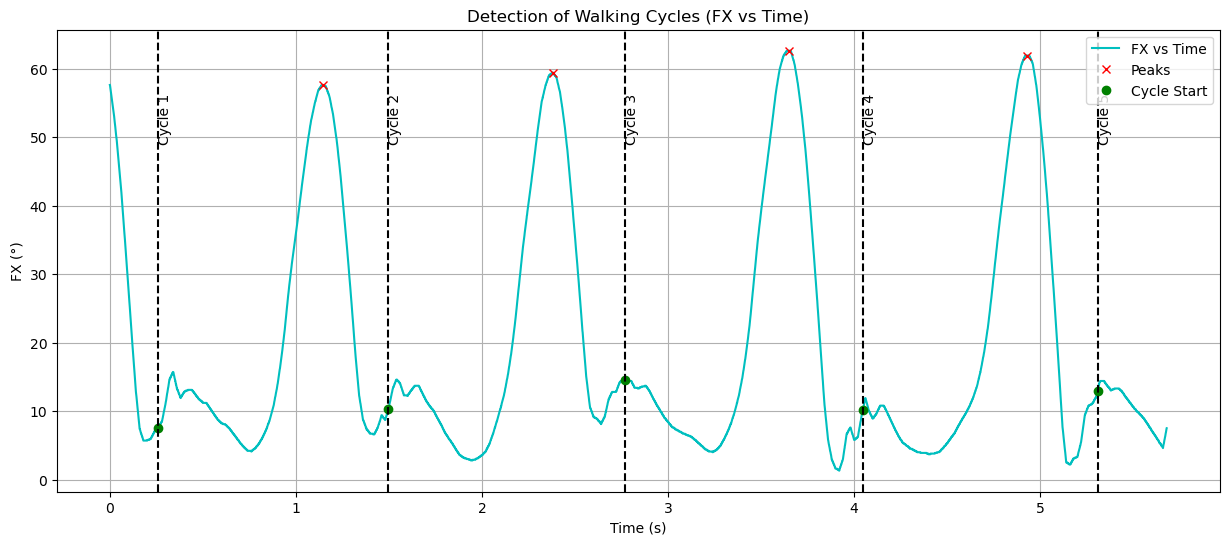

In [4]:
# Display the FX signal with marked cycles
plt.figure(figsize=(15, 6))

# Plot the FX signal over time
plt.plot(data['Time'], data['FX'], label='FX vs Time', color='c')

# Mark the detected peaks with red 'x'
plt.plot(data['Time'][peaks], data['FX'][peaks], 'rx', label='Peaks')

# Mark the adjusted cycle starts with green 'o'
plt.plot(data['Time'][adjusted_peaks], data['FX'][adjusted_peaks], 'go', label='Cycle Start')

# Add vertical lines and labels for each cycle start
for i, start in enumerate(adjusted_peaks):
    plt.axvline(x=data['Time'][start], color='k', linestyle='--')  # Vertical line at cycle start
    plt.text(data['Time'][start], max(data['FX']) * 0.9, f'Cycle {i+1}', rotation=90, verticalalignment='top')  # Label the cycle

# Add labels, title, legend, and grid
plt.xlabel('Time (s)')  # Time in seconds
plt.ylabel('FX (°)')  # Angle in degrees (° is the unit for angles)
plt.title('Detection of Walking Cycles (FX vs Time)')  # Title with units
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


##### Display of the average walking cycle time

In [5]:
# Calculate the duration of each cycle in seconds by dividing the difference of adjusted peaks by the sampling frequency (1000 Hz)
cycle_durations = np.diff(adjusted_peaks) / 1000 

# Compute the average cycle duration
average_cycle_time = np.mean(cycle_durations)

# Print the duration of each cycle and the average cycle time
print(f"Duration of each cycle (in seconds): {cycle_durations}")
print(f"Average cycle time (in seconds): {average_cycle_time}")

Duration of each cycle (in seconds): [1.236 1.269 1.281 1.262]
Average cycle time (in seconds): 1.262


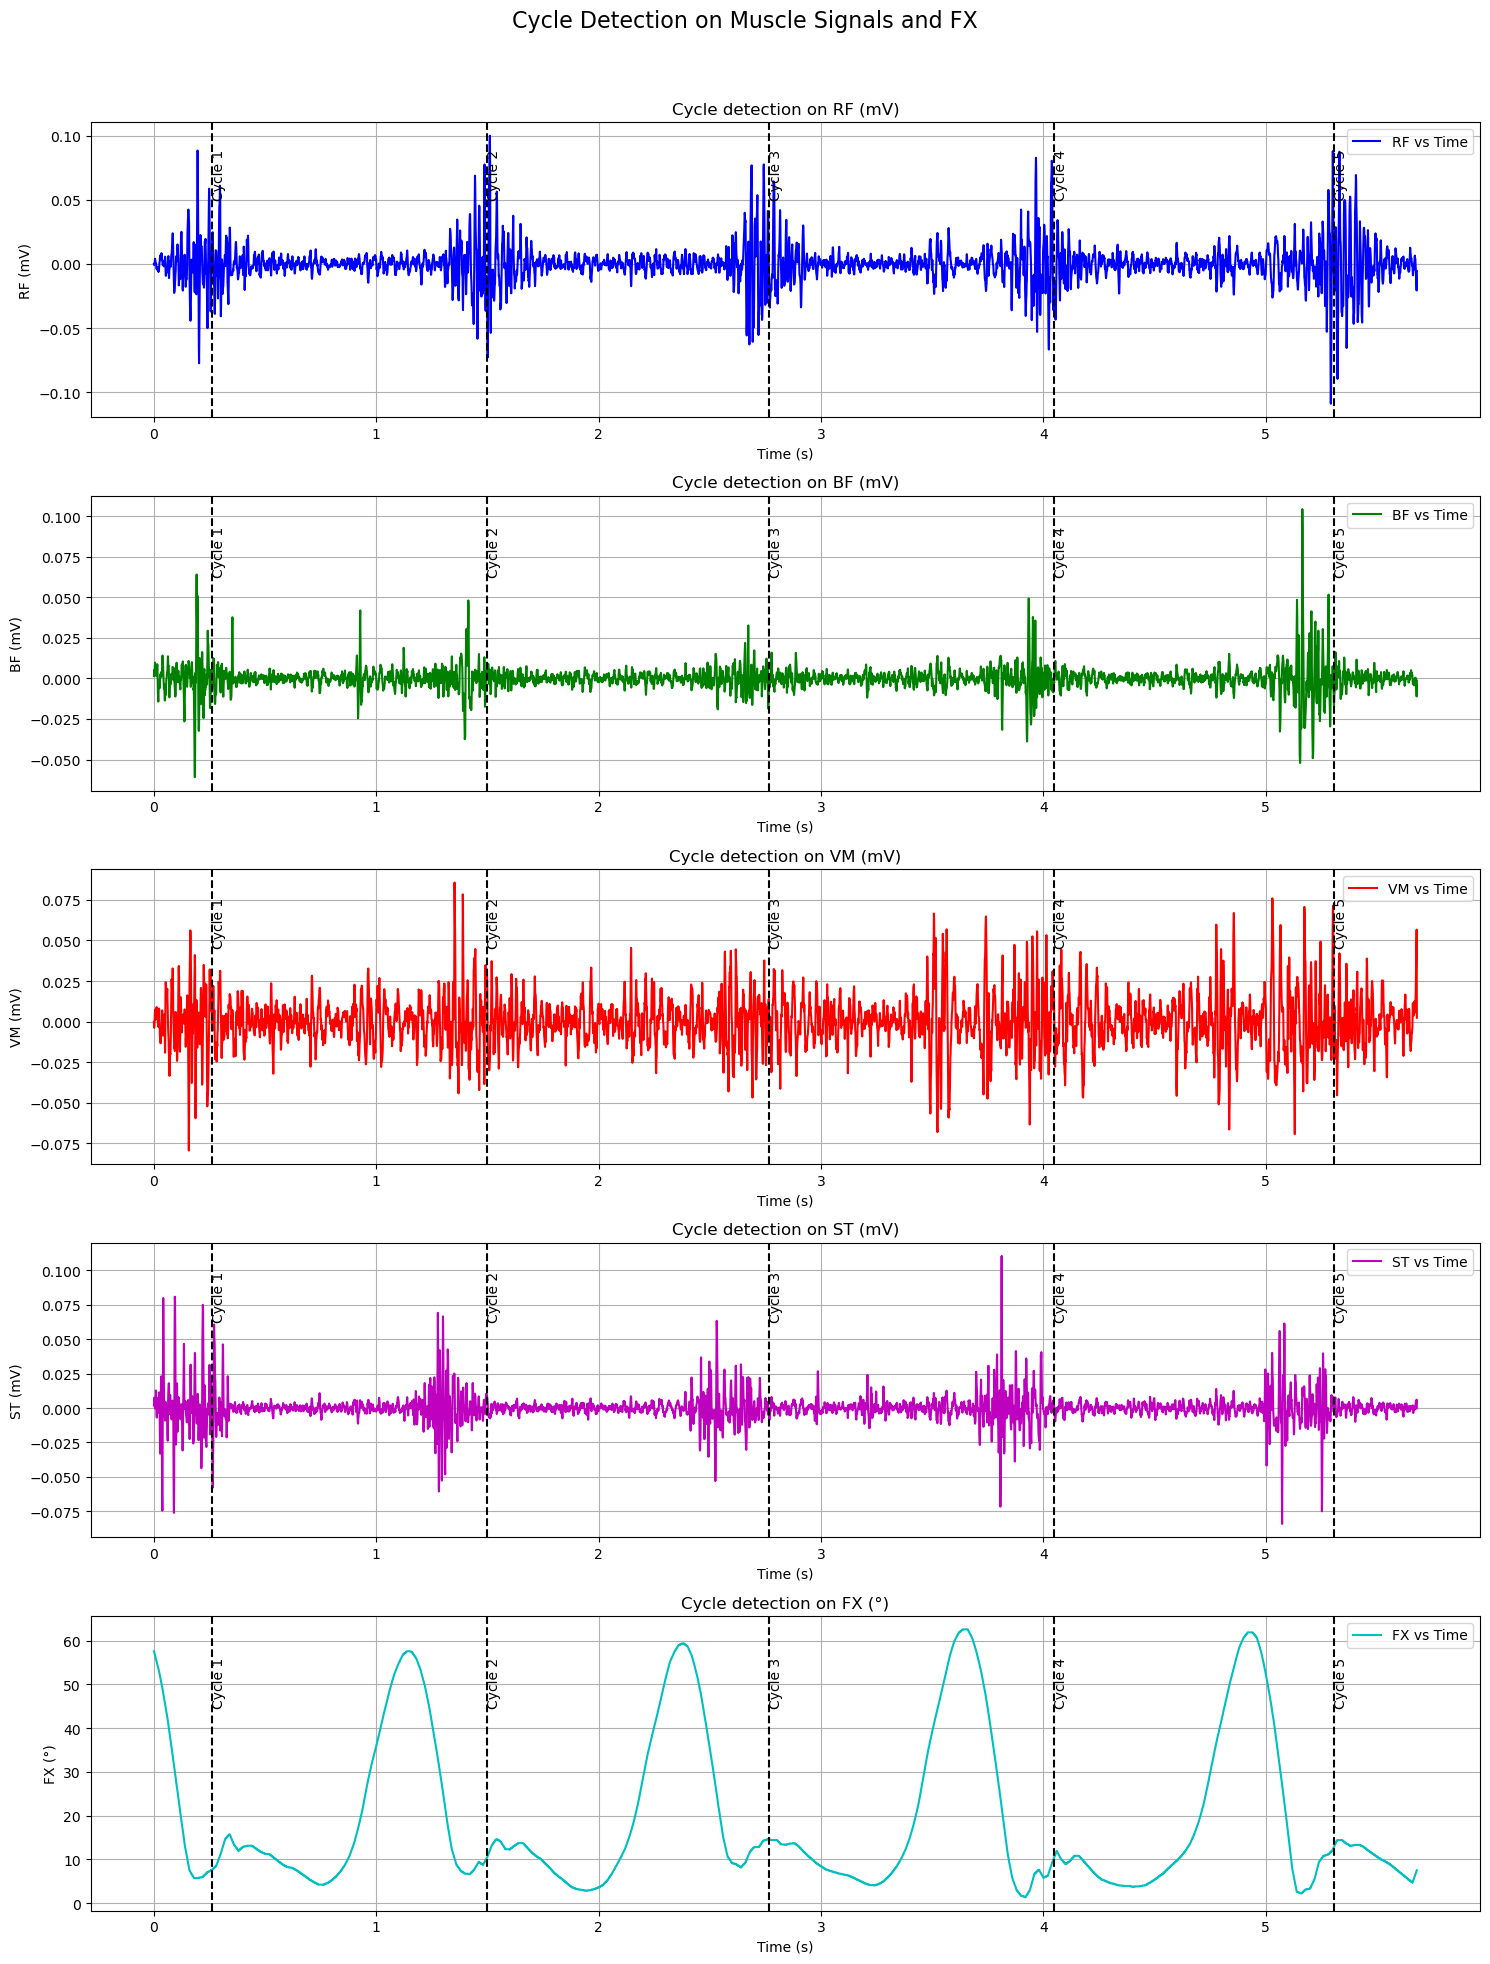

In [6]:
# List of columns to display
columns = ['RF', 'BF', 'VM', 'ST', 'FX']
colors = ['b', 'g', 'r', 'm', 'c']  # Colors for each signal

# Create subplots for each signal with marked cycles
fig, axs = plt.subplots(len(columns), figsize=(15, 20))
for i, col in enumerate(columns):
    # Plot the signal over time
    axs[i].plot(data['Time'], data[col], label=f'{col} vs Time', color=colors[i])
    
    # Mark the detected cycle starts with vertical lines and labels
    for j, start in enumerate(adjusted_peaks):
        axs[i].axvline(x=data['Time'][start], color='k', linestyle='--')  # Vertical line at cycle start
        axs[i].text(data['Time'][start], max(data[col]) * 0.9, f'Cycle {j+1}', rotation=90, verticalalignment='top')  # Label the cycle
    
    # Set labels, title, and grid for each subplot
    axs[i].set_xlabel('Time (s)')  # Time in seconds
    axs[i].set_ylabel(f'{col} (mV)' if col != 'FX' else f'{col} (°)')  # Unit in mV or degrees
    axs[i].set_title(f'Cycle detection on {col} ({ "mV" if col != "FX" else "°" })')  # Title with units
    axs[i].legend()
    axs[i].grid(True)

# Add a global title for the entire figure
fig.suptitle('Cycle Detection on Muscle Signals and FX', fontsize=16)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the global title
plt.show()

##### TIME DOMAIN

RMS (Root Mean Square)

In [7]:
# Convert float values in adjusted_peaks to integers
adjusted_peaks = [int(peak) for peak in adjusted_peaks]

# RMS (Root Mean Square) for each cycle
rms_values_RF = []  # List to store RMS values for RF
rms_values_BF = []  # List to store RMS values for BF
rms_values_VM = []  # List to store RMS values for VM
rms_values_ST = []  # List to store RMS values for ST

# Iterate through each cycle defined by adjusted_peaks
for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]  # Start index of the cycle
    end = adjusted_peaks[i + 1]  # End index of the cycle
    
    # Calculate RMS for RF and append to the list
    rms_RF = np.sqrt(np.mean(data['RF'][start:end] ** 2))
    rms_values_RF.append(rms_RF)
    
    # Calculate RMS for BF and append to the list
    rms_BF = np.sqrt(np.mean(data['BF'][start:end] ** 2))
    rms_values_BF.append(rms_BF)
    
    # Calculate RMS for VM and append to the list
    rms_VM = np.sqrt(np.mean(data['VM'][start:end] ** 2))
    rms_values_VM.append(rms_VM)
    
    # Calculate RMS for ST and append to the list
    rms_ST = np.sqrt(np.mean(data['ST'][start:end] ** 2))
    rms_values_ST.append(rms_ST)

# Print the RMS values for each muscle
print(rms_values_RF)
print(rms_values_BF)
print(rms_values_VM)
print(rms_values_ST)

# Calculate the mean RMS for each muscle
mean_rms_RF = np.mean(rms_values_RF)
mean_rms_BF = np.mean(rms_values_BF)
mean_rms_VM = np.mean(rms_values_VM)
mean_rms_ST = np.mean(rms_values_ST)

# Print the mean RMS values
print(f'Mean RMS RF: {mean_rms_RF:.4f}')
print(f'Mean RMS BF: {mean_rms_BF:.4f}')
print(f'Mean RMS VM: {mean_rms_VM:.4f}')
print(f'Mean RMS ST: {mean_rms_ST:.4f}')

[0.011407341686538428, 0.015121806929379488, 0.013719568000378574, 0.012226933734967372]
[0.006392975611607668, 0.0044600813726965675, 0.006450845008134306, 0.01006076246434129]
[0.013468862269870329, 0.013047093459574142, 0.01750097831131646, 0.018827585328754733]
[0.010034500001228228, 0.007817508695537396, 0.009965490193745255, 0.009357143519486875]
Mean RMS RF: 0.0131
Mean RMS BF: 0.0068
Mean RMS VM: 0.0157
Mean RMS ST: 0.0093


Energy

In [8]:
# Energy for each cycle

# Initialize lists to store energy values for each muscle
energie_values_RF = []
energie_values_BF = []
energie_values_VM = []
energie_values_ST = []

# Iterate through each cycle defined by adjusted_peaks
for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]  # Start index of the cycle
    end = adjusted_peaks[i + 1]  # End index of the cycle
    
    # Calculate energy for RF and append to the list
    energie_RF = np.sum(np.square(data['RF'][start:end]))
    energie_values_RF.append(energie_RF)
    
    # Calculate energy for BF and append to the list
    energie_BF = np.sum(np.square(data['BF'][start:end]))
    energie_values_BF.append(energie_BF)
    
    # Calculate energy for VM and append to the list
    energie_VM = np.sum(np.square(data['VM'][start:end]))
    energie_values_VM.append(energie_VM)
    
    # Calculate energy for ST and append to the list
    energie_ST = np.sum(np.square(data['ST'][start:end]))
    energie_values_ST.append(energie_ST)

# Print energy values for each muscle
print(energie_values_RF)
print(energie_values_BF)
print(energie_values_VM)
print(energie_values_ST)

# Calculate the mean energy for each muscle
mean_energie_RF = np.mean(energie_values_RF)
mean_energie_BF = np.mean(energie_values_BF)
mean_energie_VM = np.mean(energie_values_VM)
mean_energie_ST = np.mean(energie_values_ST)

# Print the mean energy values
print(f'Mean Energy RF: {mean_energie_RF:.4f}')
print(f'Mean Energy BF: {mean_energie_BF:.4f}')
print(f'Mean Energy VM: {mean_energie_VM:.4f}')
print(f'Mean Energy ST: {mean_energie_ST:.4f}')


[0.1608375212208486, 0.2901810178631661, 0.24111820557589203, 0.18866636060181535]
[0.05051548954287449, 0.02524336150501405, 0.05330676708960222, 0.12773830400124006]
[0.22422307004409434, 0.21601761598569233, 0.39235011381390955, 0.44735119727116407]
[0.12445431117946651, 0.07755295815789476, 0.12721738434089164, 0.11049584217347534]
Mean Energy RF: 0.2202
Mean Energy BF: 0.0642
Mean Energy VM: 0.3200
Mean Energy ST: 0.1099


##### Variance

In [9]:
def calculate_variance(signal):
    # Calculate the variance of a signal
    N = len(signal)  # Number of samples
    mean = np.mean(signal)  # Mean of the signal
    variance = np.sum((signal - mean) ** 2) / (N - 1)  # Variance formula
    return variance

# Calculate the variance for each muscle signal
var_RF = calculate_variance(data['RF'])  # Variance for RF
var_BF = calculate_variance(data['BF'])  # Variance for BF
var_VM = calculate_variance(data['VM'])  # Variance for VM
var_ST = calculate_variance(data['ST'])  # Variance for ST

# Display the results
print("Temporal variance for RF:", var_RF)
print("Temporal variance for BF:", var_BF)
print("Temporal variance for VM:", var_VM)
print("Temporal variance for ST:", var_ST)


Temporal variance for RF: 0.00020905135799189332
Temporal variance for BF: 5.448585064409148e-05
Temporal variance for VM: 0.00025694029051820085
Temporal variance for ST: 0.00010013938143869248


##### ZCR (Zero Crossing Rate) 

In [10]:
def calcul_zcr(signal):
    N = len(signal)
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zcr = len(zero_crossings) / N
    return zcr

# Calcul du ZCR pour chaque muscle
zcr_RF = calcul_zcr(data['RF'])
zcr_BF = calcul_zcr(data['BF'])
zcr_VM = calcul_zcr(data['VM'])
zcr_ST = calcul_zcr(data['ST'])

# Affichage des résultats
print("Zero Crossing Rate pour RF :", zcr_RF)
print("Zero Crossing Rate pour BF :", zcr_BF)
print("Zero Crossing Rate pour VM :", zcr_VM)
print("Zero Crossing Rate pour ST :", zcr_ST)


Zero Crossing Rate pour RF : 0.1540221791938039
Zero Crossing Rate pour BF : 0.18817109663791587
Zero Crossing Rate pour VM : 0.13923604999119873
Zero Crossing Rate pour ST : 0.18394648829431437


##### Frequency Domain


Fourier Transform

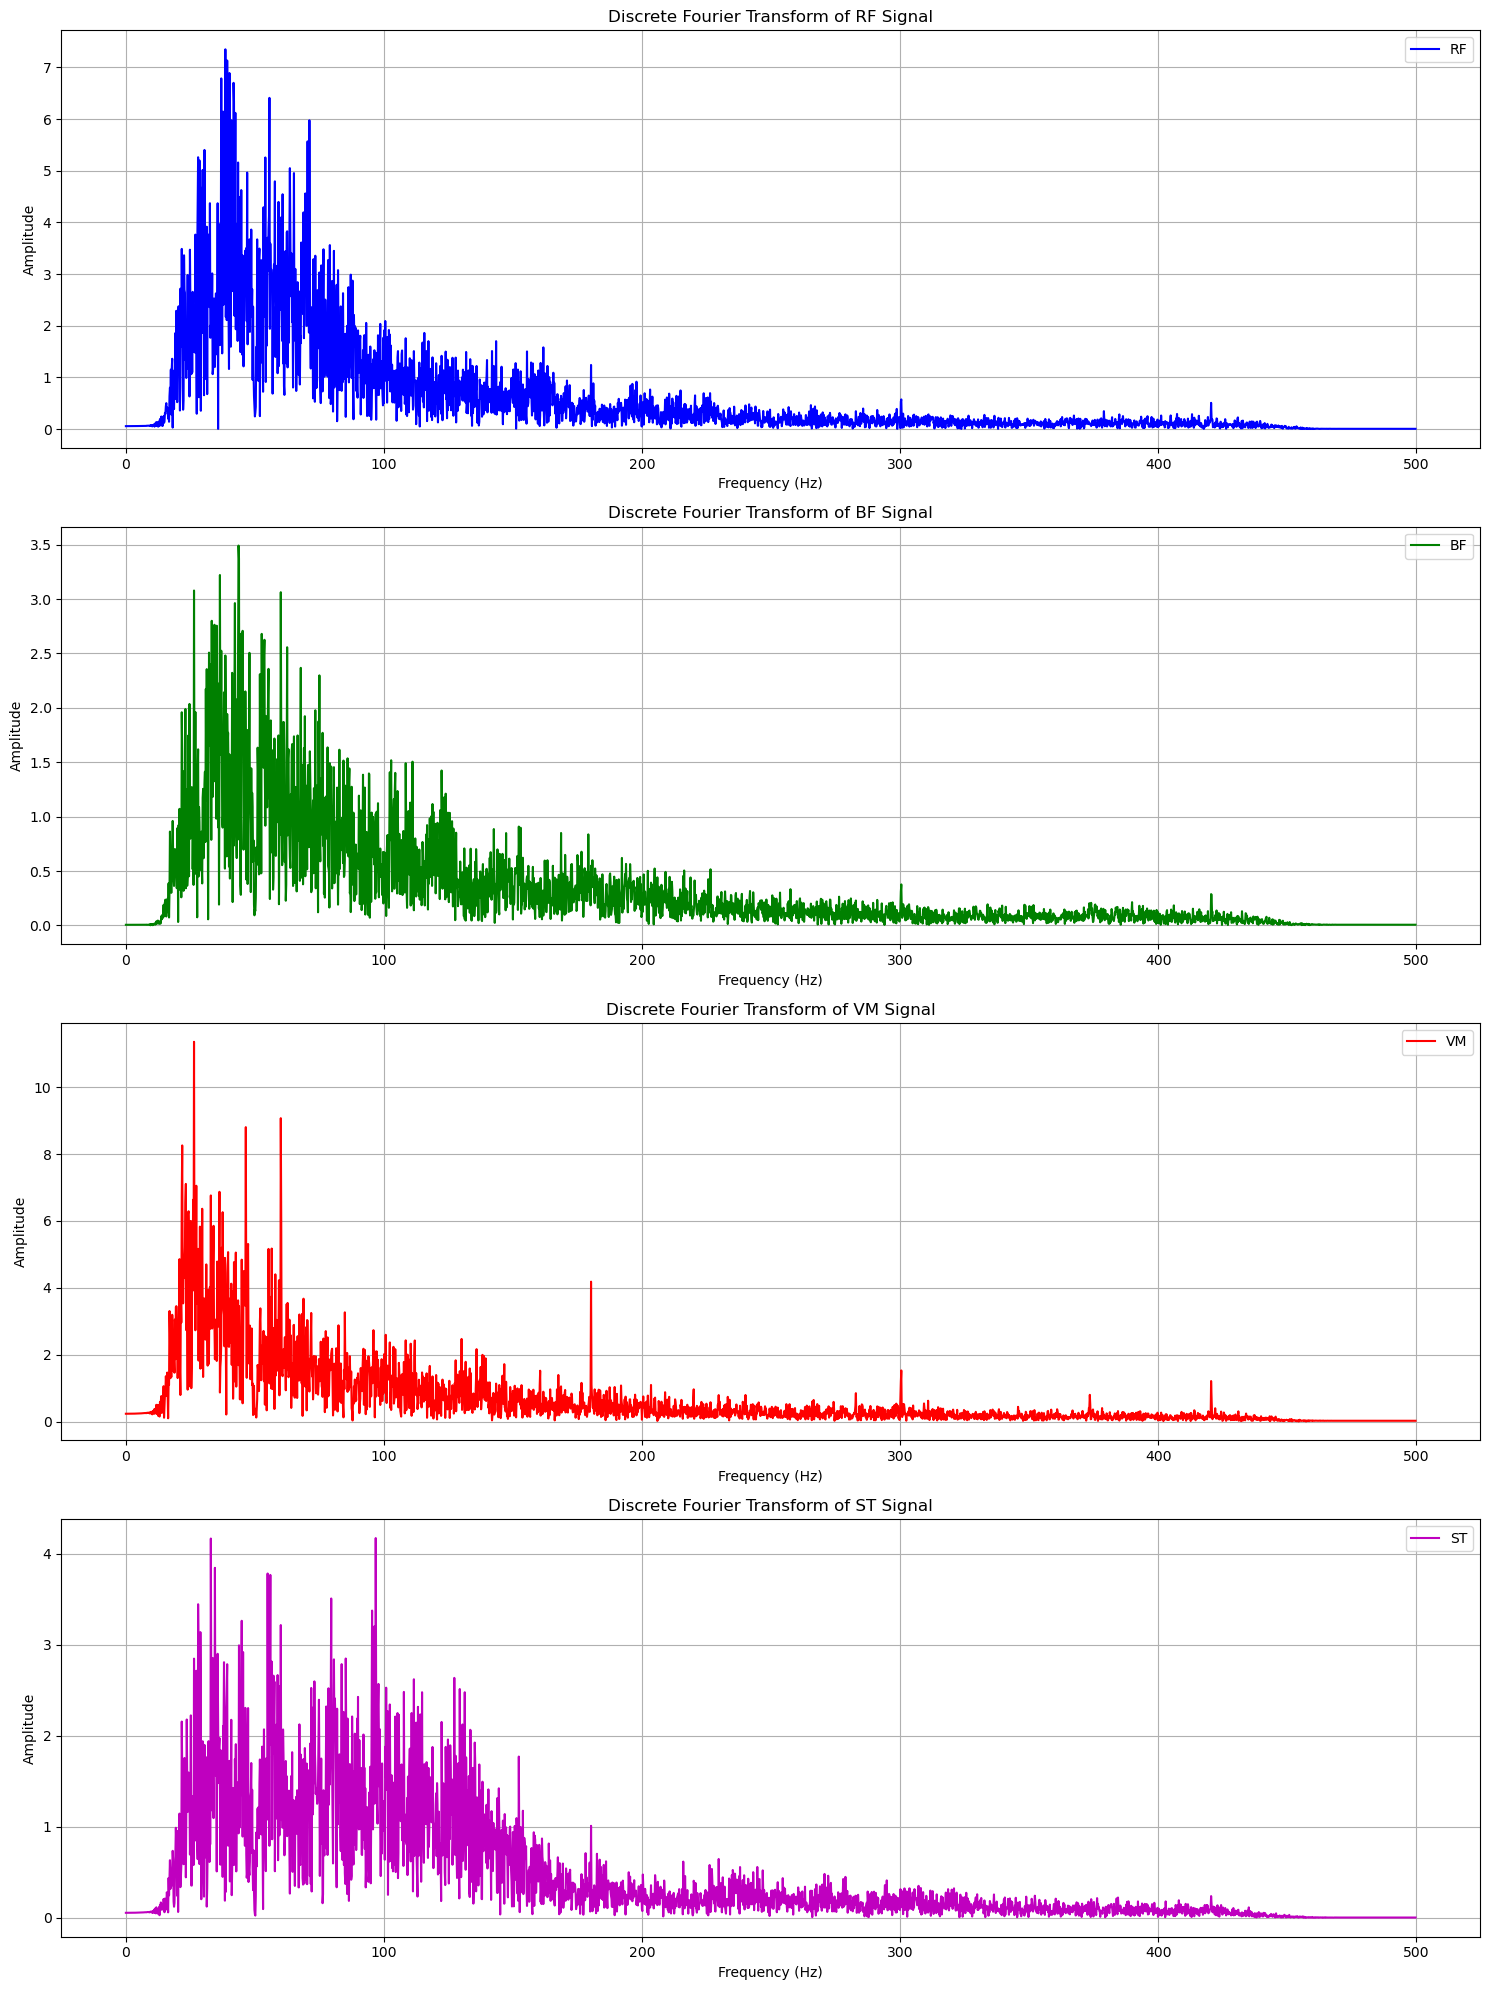

In [11]:
def transform_signal_to_frequency_domain(data, fs=1000):
    T = 1 / fs  # Sampling period

    # Compute the Discrete Fourier Transform (DFT)
    X = np.fft.fft(data)

    # Compute the associated frequencies
    n = len(data)  # Number of samples
    frequencies = np.fft.fftfreq(n, T)

    # Select positive frequencies for better visualization
    positive_frequencies = frequencies[:n // 2]
    positive_X = X[:n // 2]

    # Compute the amplitude of the frequency-domain signal
    amplitude = np.abs(positive_X)

    return positive_frequencies, amplitude

# Transform signals to the frequency domain
frequencies, amplitude_RF = transform_signal_to_frequency_domain(data['RF'])
_, amplitude_BF = transform_signal_to_frequency_domain(data['BF'])
_, amplitude_VM = transform_signal_to_frequency_domain(data['VM'])
_, amplitude_ST = transform_signal_to_frequency_domain(data['ST'])

# Display frequency-domain signals on separate plots
fig, axs = plt.subplots(4, 1, figsize=(15, 20))

axs[0].plot(frequencies, amplitude_RF, label='RF', color='b')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Discrete Fourier Transform of RF Signal')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(frequencies, amplitude_BF, label='BF', color='g')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Discrete Fourier Transform of BF Signal')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(frequencies, amplitude_VM, label='VM', color='r')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('Amplitude')
axs[2].set_title('Discrete Fourier Transform of VM Signal')
axs[2].legend()
axs[2].grid(True)

axs[3].plot(frequencies, amplitude_ST, label='ST', color='m')
axs[3].set_xlabel('Frequency (Hz)')
axs[3].set_ylabel('Amplitude')
axs[3].set_title('Discrete Fourier Transform of ST Signal')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()


##### MF (Mean Frequency)

In [13]:
# Convert the peak values to integers
adjusted_peaks = [int(peak) for peak in adjusted_peaks]

# Initialize lists to store Mean Frequency (MF) for each cycle
mf_values_RF = []
mf_values_BF = []
mf_values_VM = []
mf_values_ST = []

# Calculate the power of the frequency-domain signal
power_RF = amplitude_RF ** 2
power_BF = amplitude_BF ** 2
power_VM = amplitude_VM ** 2
power_ST = amplitude_ST ** 2

# Calculate the Mean Frequency (MF) for each muscle
mf_RF = np.sum(frequencies * power_RF) / np.sum(power_RF)
mf_BF = np.sum(frequencies * power_BF) / np.sum(power_BF)
mf_VM = np.sum(frequencies * power_VM) / np.sum(power_VM)
mf_ST = np.sum(frequencies * power_ST) / np.sum(power_ST)

# Display the results
print("MF for RF:", mf_RF)
print("MF for BF:", mf_BF)
print("MF for VM:", mf_VM)
print("MF for ST:", mf_ST)


MF for RF: 61.822397142311665
MF for BF: 69.52056514917344
MF for VM: 56.222313215416975
MF for ST: 83.29321977241435


##### MDF (Median Frequency)

In [14]:
def calculate_mdf(frequencies, power):
    cumulative_power = np.cumsum(power)
    total_power = cumulative_power[-1]
    half_power = total_power / 2

    # Find the index where the cumulative power exceeds half of the total power
    idx = np.where(cumulative_power >= half_power)[0][0]

    # Corresponding frequency
    return frequencies[idx]

# Calculate the Median Frequencies (MDF)
mdf_RF = calculate_mdf(frequencies, power_RF)
mdf_BF = calculate_mdf(frequencies, power_BF)
mdf_VM = calculate_mdf(frequencies, power_VM)
mdf_ST = calculate_mdf(frequencies, power_ST)

# Display the results
print("MDF for RF:", mdf_RF)
print("MDF for BF:", mdf_BF)
print("MDF for VM:", mdf_VM)
print("MDF for ST:", mdf_ST)

MDF for RF: 52.98362964266855
MDF for BF: 54.21580707621898
MDF for VM: 39.605703221263866
MDF for ST: 78.50730505192747


##### Spectral Entropy

In [15]:
def calculate_spectral_entropy(power):
    # Normalize the power values to obtain P(f_k)
    power_sum = np.sum(power)
    if power_sum == 0:
        return 0  # Avoid division by zero
    P = power / power_sum

    # Remove zeros to avoid log(0)
    P_nonzero = P[P > 0]

    # Spectral entropy
    entropy = -np.sum(P_nonzero * np.log(P_nonzero))
    return entropy

# Calculate spectral entropy for each muscle
se_RF = calculate_spectral_entropy(power_RF)
se_BF = calculate_spectral_entropy(power_BF)
se_VM = calculate_spectral_entropy(power_VM)
se_ST = calculate_spectral_entropy(power_ST)

# Display the results
print("Spectral Entropy for RF:", se_RF)
print("Spectral Entropy for BF:", se_BF)
print("Spectral Entropy for VM:", se_VM)
print("Spectral Entropy for ST:", se_ST)

Spectral Entropy for RF: 5.9907371030748955
Spectral Entropy for BF: 6.186899668699085
Spectral Entropy for VM: 5.918192673493877
Spectral Entropy for ST: 6.3652879429927545
